In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle, islice
from os import listdir, path
from os.path import isfile, join
from PIL import Image
import numpy as np
import math
from datetime import datetime
import tensorflow as tf
import h5py

In [2]:
def with_white_bg(img):
    white_bg = Image.new(mode=img.mode, size=img.size, color='white')
    white_bg.paste(img, mask=img)
    return white_bg


def red(image):
    arr = np.asarray(image).copy()
    rgb = arr[:,:,1:3]
    arr[:,:,1:3][np.where(rgb == 255)] = 0
    red_rank = Image.fromarray(arr)
    return with_white_bg(red_rank)


def black(image):
    arr = np.asarray(image).copy()
    rgb = arr[:,:,0:3]
    arr[:,:,0:3][np.where(rgb == 255)] = 0
    black_rank = Image.fromarray(arr)
    return with_white_bg(black_rank)


def affine(img, angle, center, new_center, scale):
    angle = -angle/180.0*math.pi
    nx,ny = x,y = center
    sx=sy=1.0
    (nx,ny) = new_center
    (sx,sy) = scale
    cosine = math.cos(angle)
    sine = math.sin(angle)
    a = cosine/sx
    b = sine/sx
    c = x-nx*a-ny*b
    d = -sine/sy
    e = cosine/sy
    f = y-nx*d-ny*e
    
    fff = Image.new(img.mode, img.size, (255,)*len(img.mode))
    warped_img = img.transform(img.size, Image.AFFINE, (a,b,c,d,e,f))
    img = Image.composite(warped_img, fff, warped_img)
    
    return img


def warp(image, lvl):
    r = lambda v: v * (.5 - np.random.rand()) * lvl
    width, height = image.size
    
    angle = r(45)
    center = width/2 + r(width/4), height/2 + r(height/4)
    new_center = width/2 + r(width/4), height/2 + r(height/4)
    scale = 1 + r(.5), 1 + r(.5)
    
    return affine(image, angle, center, new_center, scale)

class Samples(object):
    def __init__(self, images_dir, mode='L', warp_lvl=.5, one_hot=True):
        self.images_dir = images_dir
        self.mode = mode
        self.warp_lvl = warp_lvl
        self.one_hot = one_hot
        
        samples = list(self.read_images(images_dir))
        self.images, self.labels = zip(*samples)
        
        self.vocabulary = sorted(list(set(self.labels)))
        self.labels = [self.vocabulary.index(lbl) for lbl in self.labels]
        
        if self.one_hot:
            one_hot = np.zeros((len(self.labels), len(self.vocabulary)))
            idx = np.arange(len(self.labels))
            one_hot[idx, self.labels] = 1
            self.labels = one_hot
            
    def read_images(self, images_dir):
        for name in listdir(images_dir):
            full_path = join(images_dir, name)
            if not isfile(full_path):
                continue

            label = path.splitext(path.basename(full_path))[0]
            image = Image.open(full_path)
            red_image = red(image)
            black_image = black(image)

            yield (red_image, label)
            yield (black_image, label)
    
    def as_array(self, img):
        return np.asarray(warp(img, self.warp_lvl).convert(self.mode))/255.

    def next_batch(self, count):
        idx = np.arange(len(self.images))
        idx = list(islice(cycle(idx), 0, count))
        np.random.shuffle(idx)
        X = np.stack([self.as_array(self.images[i]) for i in idx])
        y = self.labels[idx]
        return X, y

4


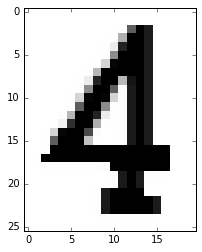

In [25]:
samples = Samples('res/cards/rank')
X, y = samples.next_batch(1000)
print(samples.vocabulary[y[800].argmax()])
plt.imshow(X[800], cmap='gray', interpolation='none')

In [621]:
X.shape, y.shape

((1000, 26, 20), (1000, 13))